# Conformal Prediction
> Tutorial on how to train neuralforecast models and obtain prediction intervals using the conformal prediction methods

Conformal prediction uses cross-validation on a model trained with a point loss function to generate prediction intervals. No additional training is needed, and the model is treated as a black box. The approach is compatible with any model.

In this notebook, we demonstrate how to obtain prediction intervals using conformal prediction.

## Load libraries

In [ ]:
import logging
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.utils import AirPassengersPanel
from neuralforecast.utils import ConformalIntervals

In [ ]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
os.environ['NIXTLA_ID_AS_COL'] = '1'

## Data

We simply use the AirPassengers dataset for the demonstration of conformal prediction.


In [ ]:
AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test['y'] = np.nan
AirPassengersPanel_test['y_[lag12]'] = np.nan

## Model training

We now train a NHITS model on the above dataset. To support conformal predictions, we must first instantiate the `ConformalIntervals` class and pass this to the `fit` method. By default, `ConformalIntervals` class employs `n_windows=2` for the corss-validation during the computation of conformity scores. 

<br>
By default, `ConformalIntervas` class employs `method=conformal_distribution` for the conformal predictions. `method=conformal_error` is also supported. The `conformal_distribution` method calculates forecast paths using the absolute errors and based on them calculates quantiles. The `conformal_error` calculates quantiles directly from errors.


In [ ]:
horizon = 12
input_size = 24

conformal_intervals = ConformalIntervals()

models = [NHITS(h=horizon, input_size=input_size, max_steps=100)]
nf = NeuralForecast(models=models, freq='ME')
nf.fit(AirPassengersPanel_train, conformal_intervals=conformal_intervals)

Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s, v_num=13, train_loss_step=10.30, train_loss_epoch=10.30]


## Forecasting

To generate conformal intervals, we specify the desired levels in the `predict` method.

In [ ]:
preds = nf.predict(futr_df=AirPassengersPanel_test, conformal_level=[10, 50, 90])

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.33it/s]


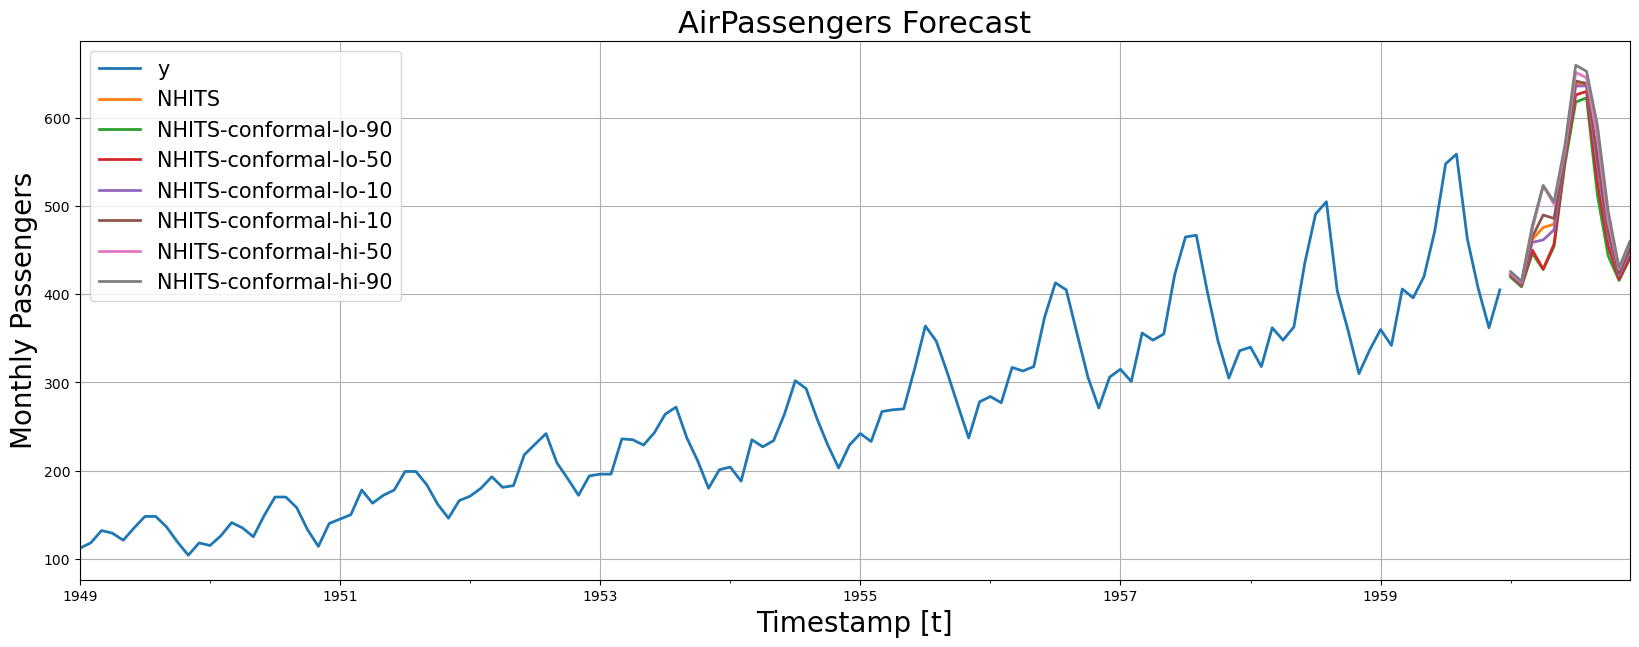

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, preds]).set_index('ds')

plot_df[plot_df['unique_id']=='Airline1'].drop(['unique_id','trend','y_[lag12]'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

## Caveat

One caveat to note is that we do not support the conformalize quantiled prediction outputs computed by loss functions such as
 * [MQLoss](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#multi-quantile-loss-mqloss)
 * [DistributionLoss](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#distributionloss)
 * [PMM](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#poisson-mixture-mesh-pmm)
 * [GMM](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#gaussian-mixture-mesh-gmm)
 * [NBMM](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#negative-binomial-mixture-mesh-nbmm)
 * [HuberQLoss](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#huberized-quantile-loss)
 * [HuberMQLoss](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#huberized-mqloss)
 * [QuantileLoss](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#quantile-loss)
 * [IQLoss](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#implicit-quantile-loss-iqloss)
 * [sCRPS](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#scaled-continuous-ranked-probability-score-scrps)
